# import libraries

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.models import ColumnDataSource, HoverTool, RangeTool
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot, column
output_notebook()
tools = ['xpan','xwheel_zoom','box_zoom','reset','save']

%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.max_columns = None

Loading BokehJS ...

# visualize flows

In [82]:
dataset = pd.read_pickle('data/dataset.pkl')

In [83]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35112 entries, 2015-01-01 00:00:00+01:00 to 2019-01-02 23:00:00+01:00
Data columns (total 15 columns):
Y                         34920 non-null float64
LOAD_FORECAST             35064 non-null float64
GENERATION_FORECAST       35040 non-null float64
SOLAR                     34833 non-null float64
WIND_ONSHORE              34830 non-null float64
crossborder_flow_FR-BE    35064 non-null float64
crossborder_flow_BE-FR    35064 non-null float64
crossborder_flow_FR-CH    35063 non-null float64
crossborder_flow_CH-FR    35063 non-null float64
crossborder_flow_FR-ES    35042 non-null float64
crossborder_flow_ES-FR    35042 non-null float64
crossborder_flow_FR-DE    35064 non-null float64
crossborder_flow_DE-FR    35064 non-null float64
crossborder_flow_FR-IT    35063 non-null float64
crossborder_flow_IT-FR    35019 non-null float64
dtypes: float64(15)
memory usage: 4.3 MB


In [84]:
dataset.describe()

,Y,LOAD_FORECAST,GENERATION_FORECAST,SOLAR,WIND_ONSHORE,crossborder_flow_FR-BE,crossborder_flow_BE-FR,crossborder_flow_FR-CH,crossborder_flow_CH-FR,crossborder_flow_FR-ES,crossborder_flow_ES-FR,crossborder_flow_FR-DE,crossborder_flow_DE-FR,crossborder_flow_FR-IT,crossborder_flow_IT-FR
count,34920.000000,35064.000000,35040.000000,34833.000000,34830.000000,35064.000000,35064.000000,35063.000000,35063.000000,35042.000000,35042.000000,35064.000000,35064.000000,35063.000000,35019.000000
mean,42.590831,54166.613336,61814.300457,955.497804,2490.794918,746.094884,326.882615,628.687135,184.840059,1443.835340,322.649735,1008.422513,193.673939,1379.019137,21.202090
std,20.212220,11881.185731,10553.518179,1326.400182,1802.876043,908.661826,539.875626,645.325304,385.304540,1045.144845,712.366046,1008.700096,422.569863,726.020716,110.337192
min,-31.820000,29650.000000,35190.000000,0.000000,134.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,45236.750000,53828.000000,0.000000,1231.000000,0.000000,0.000000,0.000000,0.000000,329.000000,0.000000,0.000000,0.000000,869.000000,0.000000
50%,40.100000,52500.000000,60393.500000,11.000000,1947.000000,333.000000,0.000000,482.000000,0.000000,1485.000000,0.000000,775.000000,0.000000,1461.000000,0.000000
75%,52.110000,62350.000000,69171.000000,1857.000000,3207.000000,1326.000000,525.000000,1064.000000,152.000000,2362.000000,0.000000,1690.000000,99.000000,1915.000000,0.000000
max,874.010000,95150.000000,92944.000000,5103.000000,12547.000000,4167.000000,3209.000000,3769.000000,2927.000000,5567.000000,3447.000000,4951.000000,3482.000000,3445.000000,1502.000000


Initial cleaning, we wanna drop nan values, but also we wanna keep almost all of the dependant variable values.
So what we can remove all rows where 'Y' is nan and interpolate the rest of the rows

In [85]:
dataset = dataset.loc[np.isfinite(dataset['Y'])]
dataset = dataset.interpolate(method='linear')

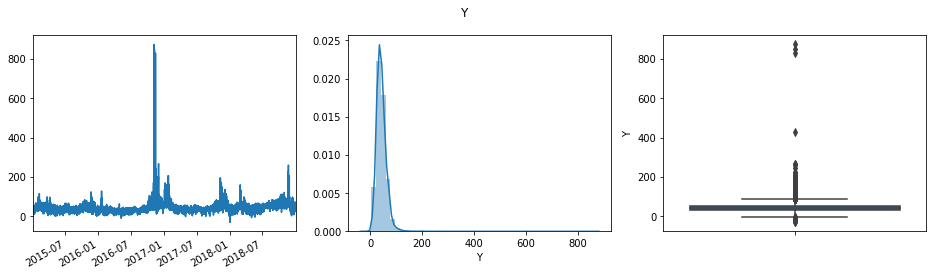

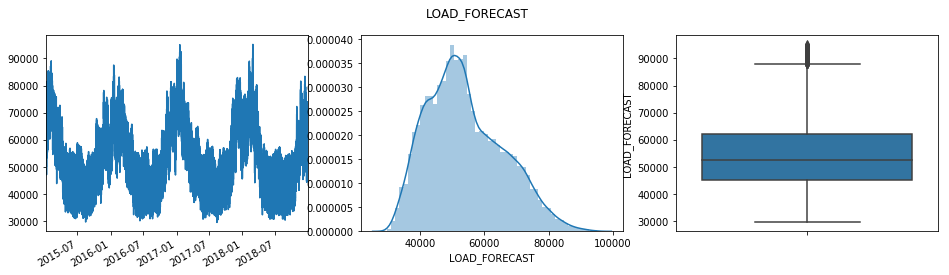

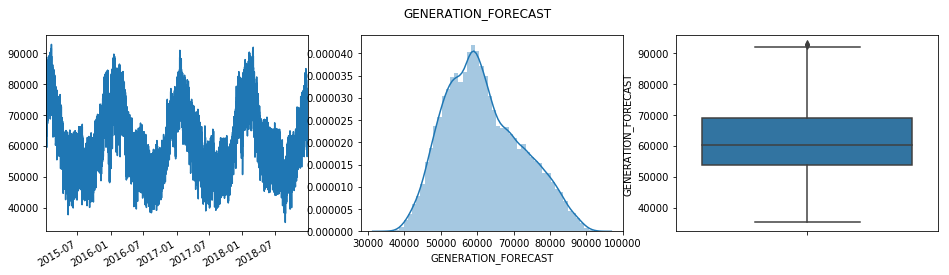

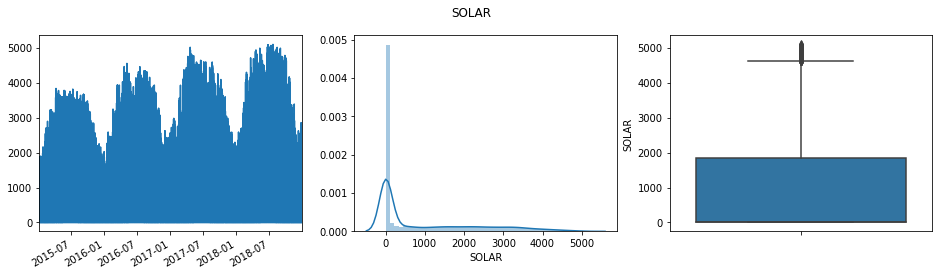

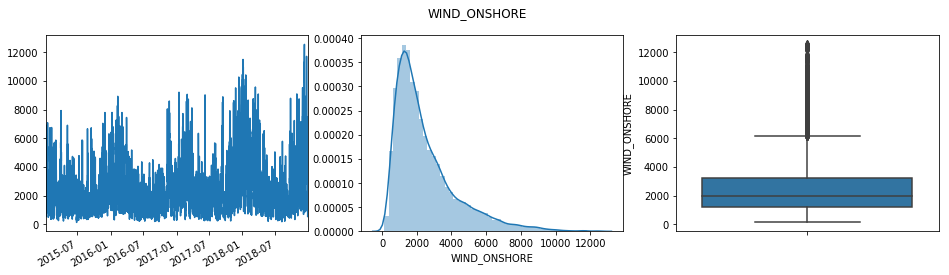

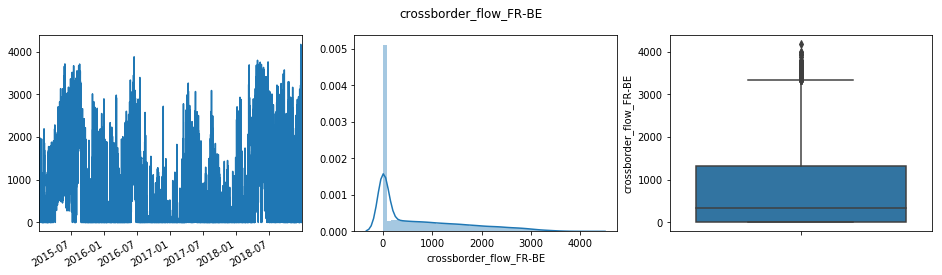

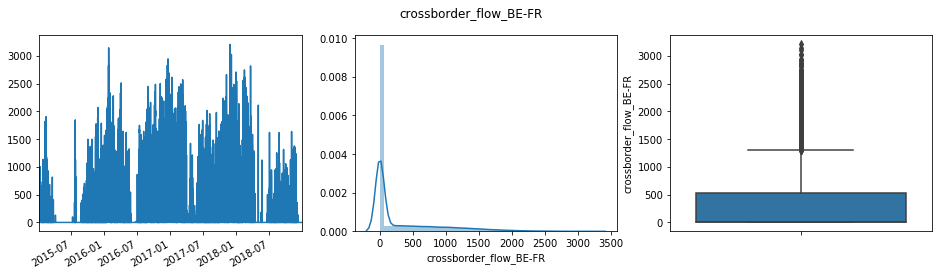

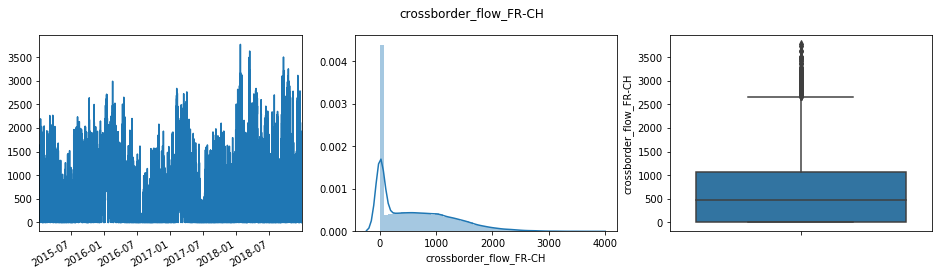

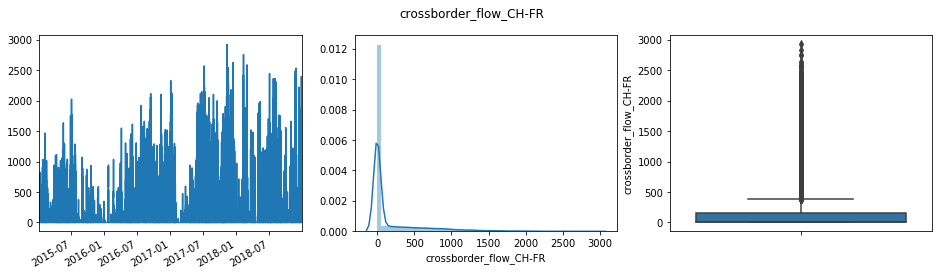

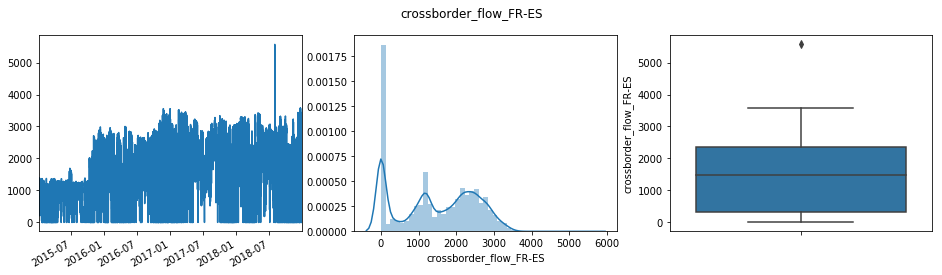

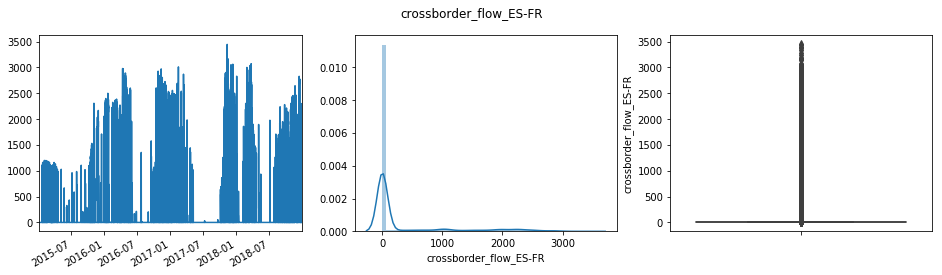

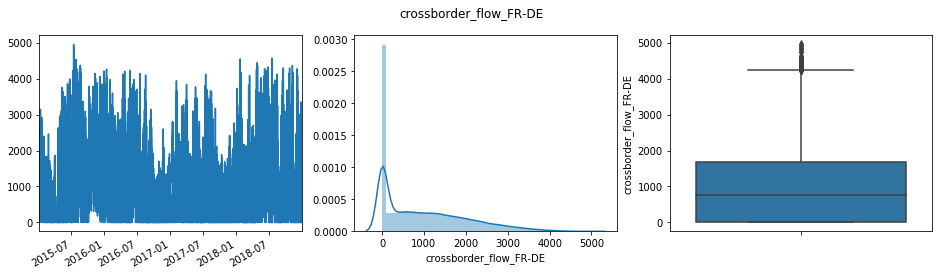

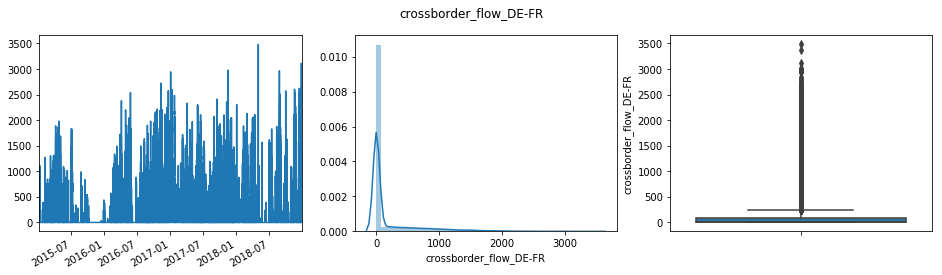

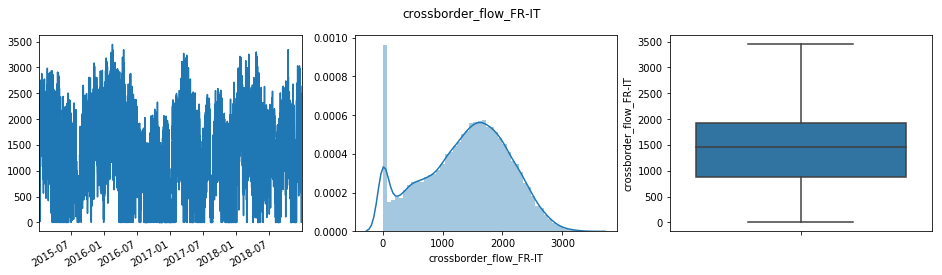

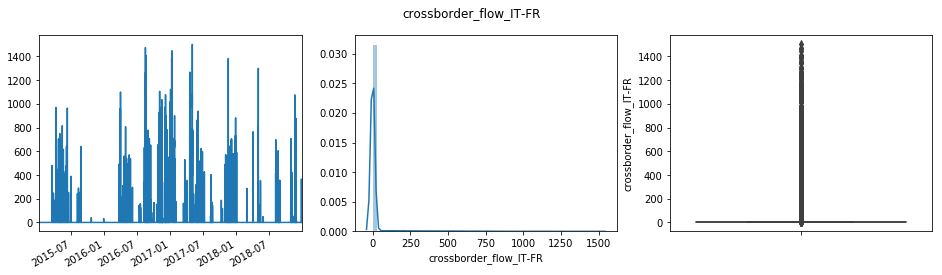

In [86]:
for c in dataset.columns:
    fig, ax = plt.subplots(1,3,figsize=(16,4))
    dataset[c].plot(ax=ax[0])
    sns.distplot(dataset[c], ax=ax[1])
    sns.boxplot(dataset[c], orient='v', ax=ax[2])
    plt.suptitle(c)
    plt.show()

# anomaly removing

I don't know how France price is formated, so I can't say exactly if highest/lowest values are related to some physical characteristics (very low temperatures, low renewable production, unavailability of some big plants) or if there were some trading speculations, so we can simply remove values >= 400€ for dependant variables.

In [87]:
print('before anomaly removing: ', dataset.shape)
dataset = dataset.loc[dataset['Y'] <= 250]
print('after anomaly removing: ', dataset.shape)

before anomaly removing:  (34920, 15)
after anomaly removing:  (34913, 15)


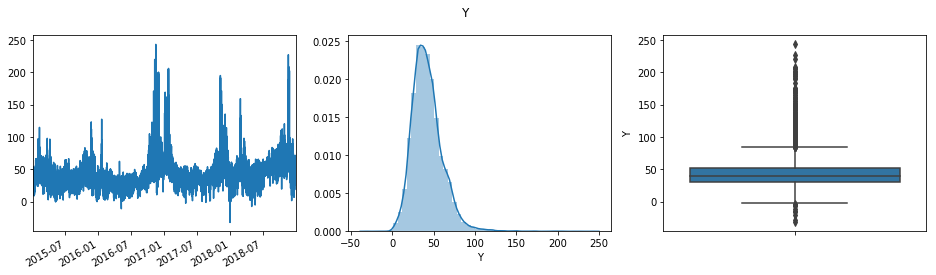

In [88]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
dataset['Y'].plot(ax=ax[0])
sns.distplot(dataset['Y'], ax=ax[1])
sns.boxplot(dataset['Y'], orient='v', ax=ax[2])
plt.suptitle('Y')
plt.show()

In [89]:
source = ColumnDataSource(data=dataset['Y'].reset_index())

fig = figure(plot_width=800, plot_height=350, x_axis_label='datetime', y_axis_label='price €',
             x_range=(dataset.index.min(), dataset.index.max()),
             x_axis_type='datetime', tools=tools)
g1 = fig.line(x='index', y='Y', source=source, legend='France Price')

ht = HoverTool(
    renderers=[g1],
    tooltips=[('datetime', '@index{%Y-%m-%d %H:%M}'), ('price', '@Y{0.2f} €')],
    formatters={'index': 'datetime'},
    mode='vline'
)
fig.add_tools(ht)

range_tool = RangeTool(x_range=fig.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

nav = figure(plot_height=90, plot_width=800, y_range=fig.y_range, x_axis_type='datetime',
             toolbar_location=None, background_fill_color='#efefef')
nav.line('index', 'Y', source=source)
nav.add_tools(range_tool)
nav.toolbar.active_multi = range_tool

show(column(fig, nav))

much better

# add some time related features
 - WeekDay
 - Month
 - Quarter
 - Hour

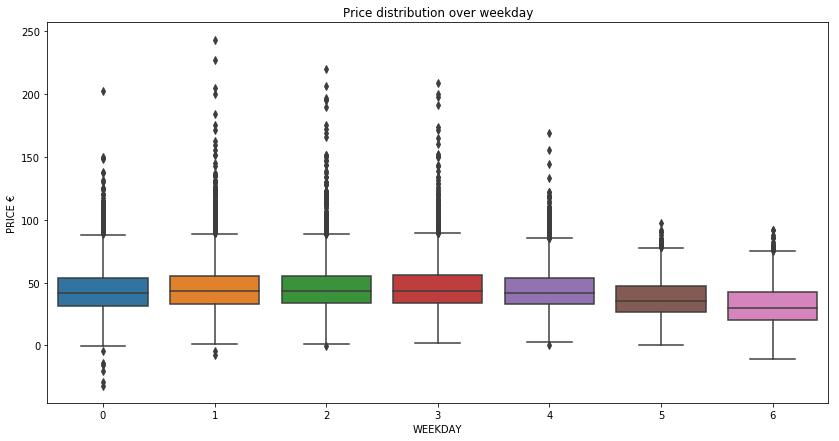

In [90]:
plt.figure(figsize=(14,7))
sns.boxplot(dataset.index.weekday, dataset['Y'])
plt.xlabel('WEEKDAY'); plt.ylabel('PRICE €')
plt.title('Price distribution over weekday')
plt.show()

as we can see on saturday and sunday prices are lower and has less spike, def we would add weekday as feature

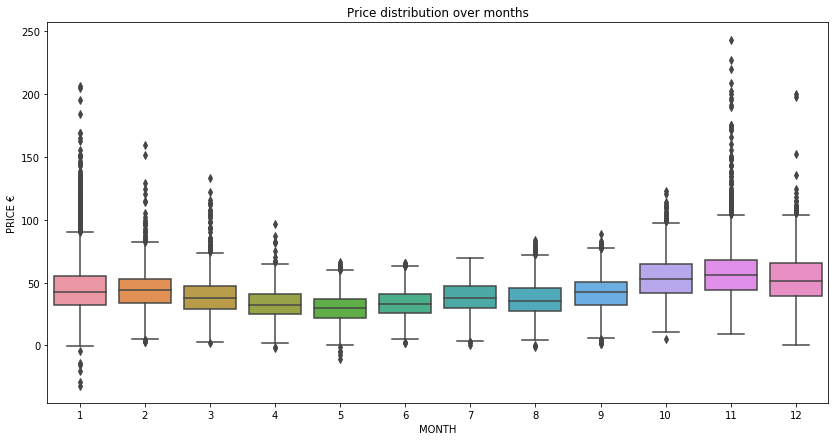

In [91]:
plt.figure(figsize=(14,7))
sns.boxplot(dataset.index.month, dataset['Y'])
plt.xlabel('MONTH'); plt.ylabel('PRICE €')
plt.title('Price distribution over months')
plt.show()

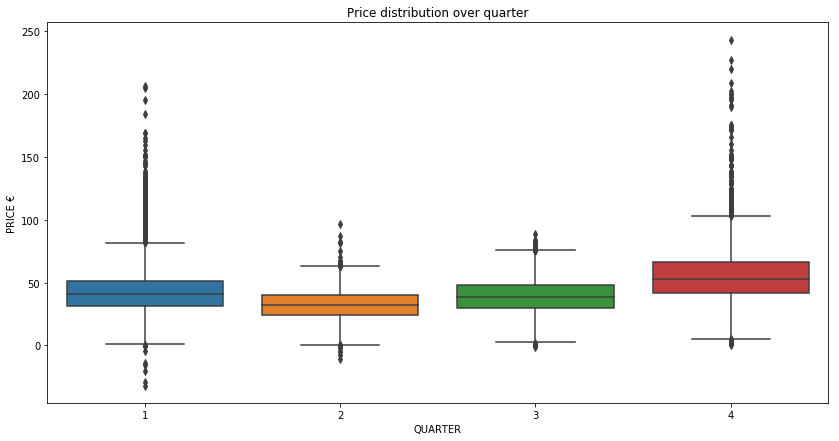

In [92]:
plt.figure(figsize=(14,7))
sns.boxplot(dataset.index.quarter, dataset['Y'])
plt.xlabel('QUARTER'); plt.ylabel('PRICE €')
plt.title('Price distribution over quarter')
plt.show()

Months that are in the same quarter have very similar pattern, so we can simply use the QUARTER

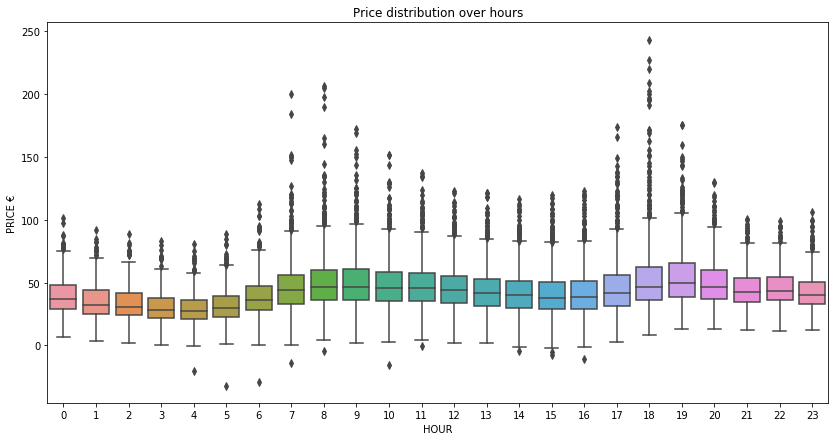

In [93]:
plt.figure(figsize=(14,7))
sns.boxplot(dataset.index.hour, dataset['Y'])
plt.xlabel('HOUR'); plt.ylabel('PRICE €')
plt.title('Price distribution over hours')
plt.show()

there are some similarities in the peak hours, we can simply add some varible to indicate peaks (8 <= hour <= 20)

Now add holiday informations, using library __holidays__

In [94]:
dataset.loc[:, 'HOLIDAY'] = 0

import holidays

for date, holiday in holidays.France(years=[2015,2016,2017,2018,2019,2020]).items(): 
    #print(pd.to_datetime(date).tz_localize('Europe/Paris'), (pd.to_datetime(date)+pd.to_timedelta(23,'h')).tz_localize('Europe/Paris'), holiday)
    dataset.loc[pd.to_datetime(date).tz_localize('Europe/Paris'):(pd.to_datetime(date)+pd.to_timedelta(23,'h')).tz_localize('Europe/Paris'), 'HOLIDAY'] = 1
dataset = dataset.dropna()

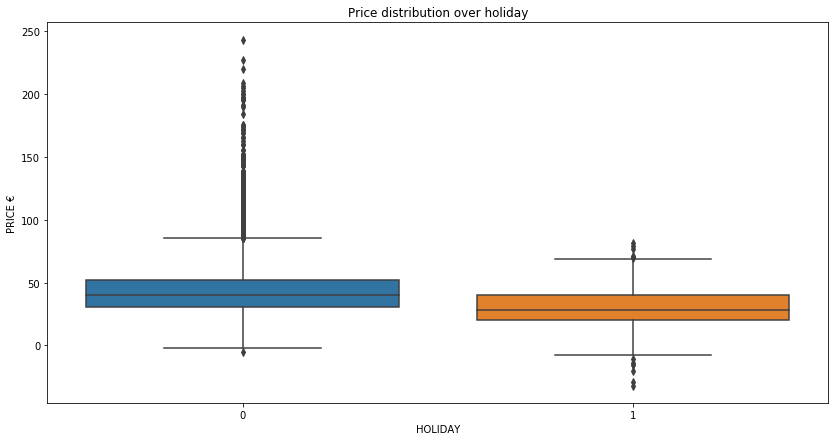

In [95]:
plt.figure(figsize=(14,7))
sns.boxplot(dataset['HOLIDAY'], dataset['Y'])
plt.xlabel('HOLIDAY'); plt.ylabel('PRICE €')
plt.title('Price distribution over holiday')
plt.show()

In [96]:
dataset.loc[:, 'WEEKDAY'] = dataset.index.weekday
dataset.loc[:, 'QUARTER'] = dataset.index.quarter
dataset.loc[:, 'HOUR'] = dataset.index.hour

dataset.loc[:, 'PEAK_HOUR'] = dataset.loc[:, 'HOUR'].apply(lambda x: 1 if x >= 8 and x <= 20  else 0, 1 )

Now we can create the dummy variables

In [97]:
dataset = dataset.merge(pd.get_dummies(dataset['WEEKDAY'], prefix='WD', drop_first=True), 
              left_index=True, right_index=True, how='inner')
dataset = dataset.merge(pd.get_dummies(dataset['QUARTER'], prefix='QRT', drop_first=True), 
              left_index=True, right_index=True, how='inner')

dataset = dataset.drop(['WEEKDAY','QUARTER','HOUR'], 1)
dataset

,Y,LOAD_FORECAST,GENERATION_FORECAST,SOLAR,WIND_ONSHORE,crossborder_flow_FR-BE,crossborder_flow_BE-FR,crossborder_flow_FR-CH,crossborder_flow_CH-FR,crossborder_flow_FR-ES,crossborder_flow_ES-FR,crossborder_flow_FR-DE,crossborder_flow_DE-FR,crossborder_flow_FR-IT,crossborder_flow_IT-FR,HOLIDAY,PEAK_HOUR,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,QRT_2,QRT_3,QRT_4
2015-01-06 00:00:00+01:00,45.56,70550.0,69634.0,0.0,1419.0,252.0,0.0,508.0,0.0,1276.0,0.0,1413.0,0.0,615.0,0.0,0,0,1,0,0,0,0,0,0,0,0
2015-01-06 01:00:00+01:00,40.28,67900.0,67965.0,0.0,1409.0,263.0,0.0,395.0,0.0,1330.0,0.0,1150.0,0.0,540.0,0.0,0,0,1,0,0,0,0,0,0,0,0
2015-01-06 02:00:00+01:00,39.20,67450.0,67433.0,0.0,1281.0,443.0,0.0,413.0,0.0,1332.0,0.0,1249.0,0.0,465.0,0.0,0,0,1,0,0,0,0,0,0,0,0
2015-01-06 03:00:00+01:00,36.22,64850.0,65739.0,0.0,1154.0,814.0,0.0,352.0,0.0,1325.0,0.0,1097.0,0.0,280.0,0.0,0,0,1,0,0,0,0,0,0,0,0
2015-01-06 04:00:00+01:00,34.04,63650.0,65466.0,0.0,1028.0,986.0,0.0,535.0,0.0,1307.0,0.0,1082.0,0.0,438.0,0.0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,58.28,65000.0,72495.0,0.0,2513.0,0.0,0.0,0.0,636.0,2814.0,0.0,0.0,1716.0,1035.0,0.0,0,1,0,0,0,0,0,0,0,0,1
2018-12-31 20:00:00+01:00,50.01,62300.0,71699.0,0.0,2449.0,0.0,0.0,0.0,479.0,3382.0,0.0,0.0,1762.0,922.0,0.0,0,1,0,0,0,0,0,0,0,0,1
2018-12-31 21:00:00+01:00,45.50,59850.0,71099.0,0.0,2385.0,0.0,0.0,0.0,77.0,3378.0,0.0,0.0,1415.0,1129.0,0.0,0,0,0,0,0,0,0,0,0,0,1
2018-12-31 22:00:00+01:00,49.80,59700.0,71237.0,0.0,2321.0,0.0,0.0,0.0,252.0,3220.0,0.0,0.0,1426.0,1013.0,0.0,0,0,0,0,0,0,0,0,0,0,1


### Correlation heatmap + PairPlot


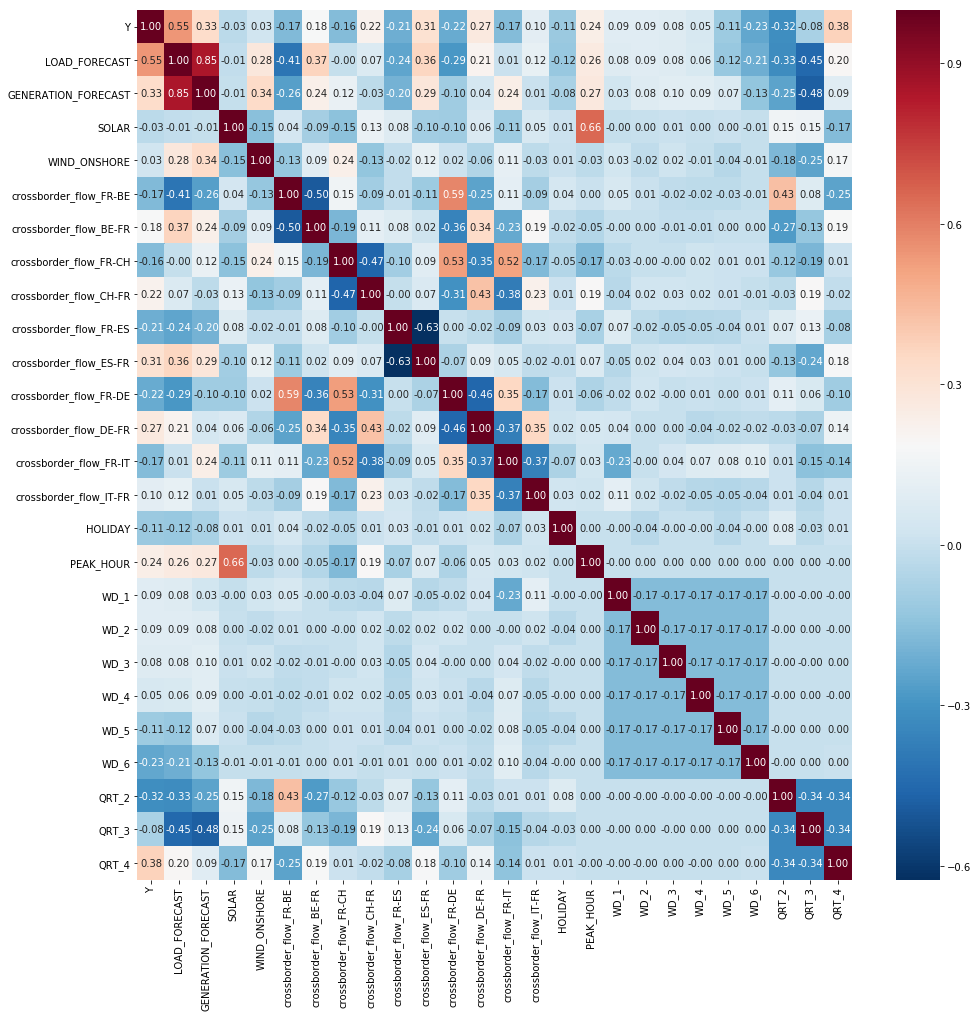

In [98]:
plt.figure(figsize=(16,16))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f', cmap='RdBu_r')
plt.show()

<Figure size 1152x1152 with 0 Axes>

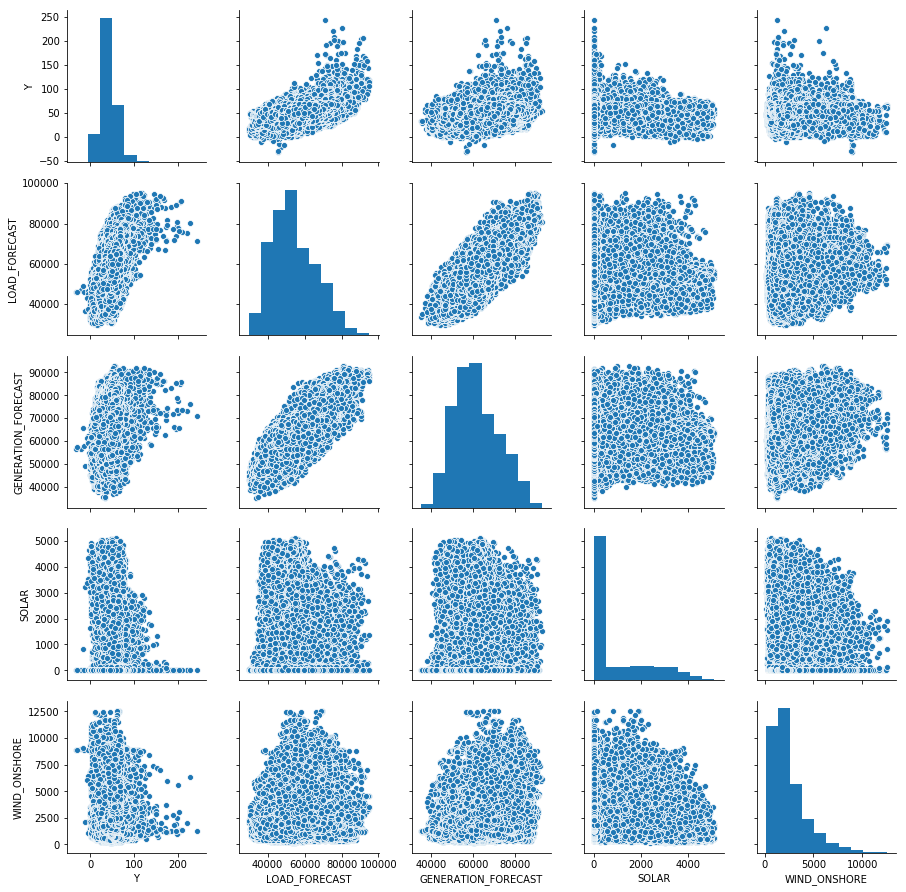

In [99]:
plt.figure(figsize=(16,16))
sns.pairplot(dataset[['Y','LOAD_FORECAST','GENERATION_FORECAST','SOLAR','WIND_ONSHORE']])
plt.show()

# TimeSeries to supervised
 - credits: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [100]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    # n_vars = 1 if type(data) is list else data.shape[1]
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)        
    
    features = df.columns
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(periods=i, freq='d'))
        names += [f'{features[j]}-{i}' for j in range(len(features))]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(periods=-i, freq='d'))
        if i == 0:
            names += [f'{features[j]}' for j in range(len(features))]
        else:
            names += [f'{features[j]}+{i}' for j in range(len(features))]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [101]:
LAGGED_OBJECTIVE = ['Y']
LAGGED_FEATURES = ['LOAD_FORECAST', 'GENERATION_FORECAST', 'SOLAR', 'WIND_ONSHORE',
                   'crossborder_flow_FR-BE', 'crossborder_flow_BE-FR',
                   'crossborder_flow_FR-CH', 'crossborder_flow_CH-FR',
                   'crossborder_flow_FR-ES', 'crossborder_flow_ES-FR',
                   'crossborder_flow_FR-DE', 'crossborder_flow_DE-FR',
                   'crossborder_flow_FR-IT', 'crossborder_flow_IT-FR',]
CATEGORICALS = ['PEAK_HOUR', 'WD_1', 'WD_2', 'WD_3', 'WD_4', 'WD_5', 'WD_6', 'QRT_2', 'QRT_3', 'QRT_4']

In [102]:
dataset_lagged = pd.concat([series_to_supervised(dataset[LAGGED_OBJECTIVE], n_in=7),
                            series_to_supervised(dataset[LAGGED_FEATURES], n_in=7),
                            dataset[CATEGORICALS]],1).dropna()
dataset_lagged

,Y-7,Y-6,Y-5,Y-4,Y-3,Y-2,Y-1,Y,LOAD_FORECAST-7,GENERATION_FORECAST-7,SOLAR-7,WIND_ONSHORE-7,crossborder_flow_FR-BE-7,crossborder_flow_BE-FR-7,crossborder_flow_FR-CH-7,crossborder_flow_CH-FR-7,crossborder_flow_FR-ES-7,crossborder_flow_ES-FR-7,crossborder_flow_FR-DE-7,crossborder_flow_DE-FR-7,crossborder_flow_FR-IT-7,crossborder_flow_IT-FR-7,LOAD_FORECAST-6,GENERATION_FORECAST-6,SOLAR-6,WIND_ONSHORE-6,crossborder_flow_FR-BE-6,crossborder_flow_BE-FR-6,crossborder_flow_FR-CH-6,crossborder_flow_CH-FR-6,crossborder_flow_FR-ES-6,crossborder_flow_ES-FR-6,crossborder_flow_FR-DE-6,crossborder_flow_DE-FR-6,crossborder_flow_FR-IT-6,crossborder_flow_IT-FR-6,LOAD_FORECAST-5,GENERATION_FORECAST-5,SOLAR-5,WIND_ONSHORE-5,crossborder_flow_FR-BE-5,crossborder_flow_BE-FR-5,crossborder_flow_FR-CH-5,crossborder_flow_CH-FR-5,crossborder_flow_FR-ES-5,crossborder_flow_ES-FR-5,crossborder_flow_FR-DE-5,crossborder_flow_DE-FR-5,crossborder_flow_FR-IT-5,crossborder_flow_IT-FR-5,LOAD_FORECAST-4,GENERATION_FORECAST-4,SOLAR-4,WIND_ONSHORE-4,crossborder_flow_FR-BE-4,crossborder_flow_BE-FR-4,crossborder_flow_FR-CH-4,crossborder_flow_CH-FR-4,crossborder_flow_FR-ES-4,crossborder_flow_ES-FR-4,crossborder_flow_FR-DE-4,crossborder_flow_DE-FR-4,crossborder_flow_FR-IT-4,crossborder_flow_IT-FR-4,LOAD_FORECAST-3,GENERATION_FORECAST-3,SOLAR-3,WIND_ONSHORE-3,crossborder_flow_FR-BE-3,crossborder_flow_BE-FR-3,crossborder_flow_FR-CH-3,crossborder_flow_CH-FR-3,crossborder_flow_FR-ES-3,crossborder_flow_ES-FR-3,crossborder_flow_FR-DE-3,crossborder_flow_DE-FR-3,crossborder_flow_FR-IT-3,crossborder_flow_IT-FR-3,LOAD_FORECAST-2,GENERATION_FORECAST-2,SOLAR-2,WIND_ONSHORE-2,crossborder_flow_FR-BE-2,crossborder_flow_BE-FR-2,crossborder_flow_FR-CH-2,crossborder_flow_CH-FR-2,crossborder_flow_FR-ES-2,crossborder_flow_ES-FR-2,crossborder_flow_FR-DE-2,crossborder_flow_DE-FR-2,crossborder_flow_FR-IT-2,crossborder_flow_IT-FR-2,LOAD_FORECAST-1,GENERATION_FORECAST-1,SOLAR-1,WIND_ONSHORE-1,crossborder_flow_FR-BE-1,crossborder_flow_BE-FR-1,crossborder_flow_FR-CH-1,crossborder_flow_CH-FR-1,crossborder_flow_FR-ES-1,crossborder_flow_ES-FR-1,crossborder_flow_FR-DE-1,crossborder_flow_DE-FR-1,crossborder_flow_FR-IT-1,crossborder_flow_IT-FR-1,LOAD_FORECAST,GENERATION_FORECAST,SOLAR,WIND_ONSHORE,crossborder_flow_FR-BE,crossborder_flow_BE-FR,crossborder_flow_FR-CH,crossborder_flow_CH-FR,crossborder_flow_FR-ES,crossborder_flow_ES-FR,crossborder_flow_FR-DE,crossborder_flow_DE-FR,crossborder_flow_FR-IT,crossborder_flow_IT-FR,PEAK_HOUR,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,QRT_2,QRT_3,QRT_4
2015-01-13 00:00:00+01:00,45.56,40.00,43.88,32.06,19.04,26.95,27.59,33.04,70550.0,69634.0,0.0,1419.0,252.0,0.0,508.0,0.0,1276.0,0.0,1413.0,0.0,615.0,0.0,71550.0,76108.0,0.0,776.0,52.0,0.0,279.0,0.0,1312.0,0.0,617.0,0.0,479.0,0.0,69500.0,76165.0,0.0,1384.0,30.0,0.0,0.0,106.0,1198.0,0.0,164.0,0.0,426.0,0.0,65850.0,78463.0,0.0,2710.0,301.0,0.0,296.0,0.0,1180.0,0.0,96.0,0.0,957.0,0.0,60850.0,76714.0,0.0,3579.0,0.0,66.0,1152.0,0.0,1163.0,0.0,1317.0,0.0,1891.0,0.0,58050.0,71189.0,0.0,6891.0,1072.0,0.0,1555.0,0.0,1113.0,0.0,2434.0,0.0,2043.0,0.0,61550.0,67515.0,0.0,3366.0,1314.0,0.0,1401.0,0.0,1205.0,0.0,2305.0,0.0,1942.0,0.0,65100.0,70218.0,0.0,4708.0,1002.0,0.0,1449.0,0.0,1186.0,0.0,1880.0,0.0,2111.0,0.0,0,1,0,0,0,0,0,0,0,0
2015-01-13 01:00:00+01:00,40.28,36.69,35.65,29.71,15.96,24.22,26.81,26.56,67900.0,67965.0,0.0,1409.0,263.0,0.0,395.0,0.0,1330.0,0.0,1150.0,0.0,540.0,0.0,68450.0,75171.0,0.0,785.0,142.0,0.0,333.0,0.0,1315.0,0.0,676.0,0.0,253.0,0.0,66500.0,74438.0,0.0,1244.0,79.0,0.0,0.0,54.0,1292.0,0.0,237.0,0.0,219.0,0.0,62550.0,76255.0,0.0,2880.0,96.0,0.0,369.0,0.0,1277.0,0.0,43.0,0.0,843.0,0.0,57200.0,74746.0,0.0,3918.0,0.0,101.0,1127.0,0.0,1266.0,0.0,1316.0,0.0,1870.0,0.0,55050.0,68925.0,0.0,6837.0,1070.0,0.0,1505.0,0.0,1245.0,0.0,2355.0,0.0,2036.0,0.0,59200.0,65642.0,0.0,3061.0,1308.0,0.0,1458.0,0.0,1150.0,0.0,2203.0,0.0,2019.0,0.0,61900.0,68886.0,0.0,4706.0,887.0,0.0,1469.0,0.0,1282.0,0.0,1942.0,0.0,1989.0,0.0,0,1,0,0,0,0,0,

In [103]:
dataset_lagged['AVG-7'] = dataset_lagged[[f'Y-{i+1}' for i in range(7)]].mean(axis=1)

In [104]:
dataset_lagged

,Y-7,Y-6,Y-5,Y-4,Y-3,Y-2,Y-1,Y,LOAD_FORECAST-7,GENERATION_FORECAST-7,SOLAR-7,WIND_ONSHORE-7,crossborder_flow_FR-BE-7,crossborder_flow_BE-FR-7,crossborder_flow_FR-CH-7,crossborder_flow_CH-FR-7,crossborder_flow_FR-ES-7,crossborder_flow_ES-FR-7,crossborder_flow_FR-DE-7,crossborder_flow_DE-FR-7,crossborder_flow_FR-IT-7,crossborder_flow_IT-FR-7,LOAD_FORECAST-6,GENERATION_FORECAST-6,SOLAR-6,WIND_ONSHORE-6,crossborder_flow_FR-BE-6,crossborder_flow_BE-FR-6,crossborder_flow_FR-CH-6,crossborder_flow_CH-FR-6,crossborder_flow_FR-ES-6,crossborder_flow_ES-FR-6,crossborder_flow_FR-DE-6,crossborder_flow_DE-FR-6,crossborder_flow_FR-IT-6,crossborder_flow_IT-FR-6,LOAD_FORECAST-5,GENERATION_FORECAST-5,SOLAR-5,WIND_ONSHORE-5,crossborder_flow_FR-BE-5,crossborder_flow_BE-FR-5,crossborder_flow_FR-CH-5,crossborder_flow_CH-FR-5,crossborder_flow_FR-ES-5,crossborder_flow_ES-FR-5,crossborder_flow_FR-DE-5,crossborder_flow_DE-FR-5,crossborder_flow_FR-IT-5,crossborder_flow_IT-FR-5,LOAD_FORECAST-4,GENERATION_FORECAST-4,SOLAR-4,WIND_ONSHORE-4,crossborder_flow_FR-BE-4,crossborder_flow_BE-FR-4,crossborder_flow_FR-CH-4,crossborder_flow_CH-FR-4,crossborder_flow_FR-ES-4,crossborder_flow_ES-FR-4,crossborder_flow_FR-DE-4,crossborder_flow_DE-FR-4,crossborder_flow_FR-IT-4,crossborder_flow_IT-FR-4,LOAD_FORECAST-3,GENERATION_FORECAST-3,SOLAR-3,WIND_ONSHORE-3,crossborder_flow_FR-BE-3,crossborder_flow_BE-FR-3,crossborder_flow_FR-CH-3,crossborder_flow_CH-FR-3,crossborder_flow_FR-ES-3,crossborder_flow_ES-FR-3,crossborder_flow_FR-DE-3,crossborder_flow_DE-FR-3,crossborder_flow_FR-IT-3,crossborder_flow_IT-FR-3,LOAD_FORECAST-2,GENERATION_FORECAST-2,SOLAR-2,WIND_ONSHORE-2,crossborder_flow_FR-BE-2,crossborder_flow_BE-FR-2,crossborder_flow_FR-CH-2,crossborder_flow_CH-FR-2,crossborder_flow_FR-ES-2,crossborder_flow_ES-FR-2,crossborder_flow_FR-DE-2,crossborder_flow_DE-FR-2,crossborder_flow_FR-IT-2,crossborder_flow_IT-FR-2,LOAD_FORECAST-1,GENERATION_FORECAST-1,SOLAR-1,WIND_ONSHORE-1,crossborder_flow_FR-BE-1,crossborder_flow_BE-FR-1,crossborder_flow_FR-CH-1,crossborder_flow_CH-FR-1,crossborder_flow_FR-ES-1,crossborder_flow_ES-FR-1,crossborder_flow_FR-DE-1,crossborder_flow_DE-FR-1,crossborder_flow_FR-IT-1,crossborder_flow_IT-FR-1,LOAD_FORECAST,GENERATION_FORECAST,SOLAR,WIND_ONSHORE,crossborder_flow_FR-BE,crossborder_flow_BE-FR,crossborder_flow_FR-CH,crossborder_flow_CH-FR,crossborder_flow_FR-ES,crossborder_flow_ES-FR,crossborder_flow_FR-DE,crossborder_flow_DE-FR,crossborder_flow_FR-IT,crossborder_flow_IT-FR,PEAK_HOUR,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,QRT_2,QRT_3,QRT_4,AVG-7
2015-01-13 00:00:00+01:00,45.56,40.00,43.88,32.06,19.04,26.95,27.59,33.04,70550.0,69634.0,0.0,1419.0,252.0,0.0,508.0,0.0,1276.0,0.0,1413.0,0.0,615.0,0.0,71550.0,76108.0,0.0,776.0,52.0,0.0,279.0,0.0,1312.0,0.0,617.0,0.0,479.0,0.0,69500.0,76165.0,0.0,1384.0,30.0,0.0,0.0,106.0,1198.0,0.0,164.0,0.0,426.0,0.0,65850.0,78463.0,0.0,2710.0,301.0,0.0,296.0,0.0,1180.0,0.0,96.0,0.0,957.0,0.0,60850.0,76714.0,0.0,3579.0,0.0,66.0,1152.0,0.0,1163.0,0.0,1317.0,0.0,1891.0,0.0,58050.0,71189.0,0.0,6891.0,1072.0,0.0,1555.0,0.0,1113.0,0.0,2434.0,0.0,2043.0,0.0,61550.0,67515.0,0.0,3366.0,1314.0,0.0,1401.0,0.0,1205.0,0.0,2305.0,0.0,1942.0,0.0,65100.0,70218.0,0.0,4708.0,1002.0,0.0,1449.0,0.0,1186.0,0.0,1880.0,0.0,2111.0,0.0,0,1,0,0,0,0,0,0,0,0,33.582857
2015-01-13 01:00:00+01:00,40.28,36.69,35.65,29.71,15.96,24.22,26.81,26.56,67900.0,67965.0,0.0,1409.0,263.0,0.0,395.0,0.0,1330.0,0.0,1150.0,0.0,540.0,0.0,68450.0,75171.0,0.0,785.0,142.0,0.0,333.0,0.0,1315.0,0.0,676.0,0.0,253.0,0.0,66500.0,74438.0,0.0,1244.0,79.0,0.0,0.0,54.0,1292.0,0.0,237.0,0.0,219.0,0.0,62550.0,76255.0,0.0,2880.0,96.0,0.0,369.0,0.0,1277.0,0.0,43.0,0.0,843.0,0.0,57200.0,74746.0,0.0,3918.0,0.0,101.0,1127.0,0.0,1266.0,0.0,1316.0,0.0,1870.0,0.0,55050.0,68925.0,0.0,6837.0,1070.0,0.0,1505.0,0.0,1245.0,0.0,2355.0,0.0,2036.0,0.0,59200.0,65642.0,0.0,3061.0,1308.0,0.0,1458.0,0.0,1150.0,0.0,2203.0,0.0,2019.0,0.0,61900.0,68886.0,0.0,4706.0,887.0,0.0,1469.0,0.0,1282.0,0.0,1942.0,0.0,1989.0,0.

In [105]:
dataset_lagged.to_pickle('data/dataset_eda.pkl')